# Investigate Distribution of Returns for SPY

This notebook investigates the returns on SPY for the last ten years.

### Import & Format Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, gaussian_kde, levy_stable # distributions
from scipy.stats import kstest, chisquare # goodness-of-fit tests
from datetime import datetime, timedelta

In [2]:
spy = pd.read_csv('./data/price/SPY.csv', index_col='Date', parse_dates=True)
print('SPY\t', spy.shape)

# Limit data to last ten years
ten_years = 255*10
spy = spy.iloc[-ten_years:]
print('SPY 10y\t', spy.shape)

SPY	 (6688, 6)
SPY 10y	 (2550, 6)


In [3]:
df = pd.DataFrame(spy['Adj Close'].rename('price'))
df['pct_change'] = df.price.pct_change()
df['log_return'] = np.log(df.price).diff()
df = df.iloc[1:]
y = df['log_return']

### Inspect Data

In [4]:
moment_stats = []
_, _, y_mean, y_var, y_skew, y_kurt = stats.describe(y)
moment_stats.append(['actual', y_mean, y_var, y_skew, y_kurt])
pd.DataFrame(moment_stats, columns=['name', 'mean', 'variance', 'skew', 'kurtosis']).set_index('name')

,mean,variance,skew,kurtosis
name,,,,
actual,0.000539,0.000089,-0.480997,4.182856


### Normal Distribution

The data is fit into a normal distribution and then compared to the original data.

In [5]:
# Fit data to normal distribution
mu_normal, std_normal = norm.fit(y)

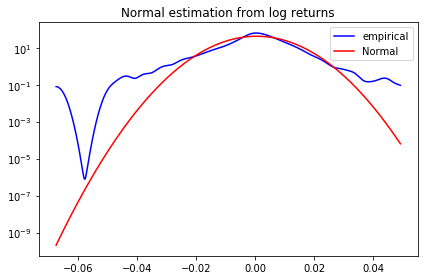

In [6]:
# find limits and generate linspace
xmin, xmax = y.min(), y.max()
x = np.linspace(xmin, xmax, min(500, y.shape[0]))

# Estimate density from data
kde = gaussian_kde(y)
kde_pdf = kde.pdf(x)

# find pdf from normal distribution fit
normal_pdf = norm.pdf(x, mu_normal, std_normal)

def plot_model_pdf(empirical_pdf, dist_pdf, dist_name, plot_log=False):
    plt.plot(x, empirical_pdf, 'b', label='empirical')
    plt.plot(x, dist_pdf, 'r', label=dist_name)
    
    if plot_log:
        plt.yscale('log')
    plt.title('{} estimation from log returns'.format(dist_name))
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_model_pdf(kde_pdf, normal_pdf, 'Normal', plot_log=True)

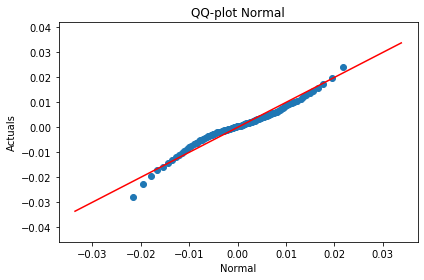

In [7]:
def qq_plot(actuals, simulated, dist_name):
    quantiles = np.linspace(0.01, 0.99, 100)
    actuals_q = np.quantile(actuals, quantiles) 
    normal_sim_q = np.quantile(simulated, quantiles)
    
    plt.scatter(normal_sim_q, actuals_q)

    xmin, xmax = plt.xlim()
    x_sim = np.linspace(xmin, xmax, 100)
    plt.plot(x_sim, x_sim, 'r')

    plt.title('QQ-plot {}'.format(dist_name))
    plt.xlabel(dist_name)
    plt.ylabel('Actuals')
    plt.tight_layout()
    plt.show()

normal_sim = norm.rvs(mu_normal, std_normal, size=y.shape[0], random_state=69)
qq_plot(y, normal_sim, 'Normal')

### Levy-Stable Distribution

In [8]:
# Fit to Levy-Stable distribution
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
alpha, beta, mu, sigma = lev_p = pconv(*levy_stable._fitstart(y))

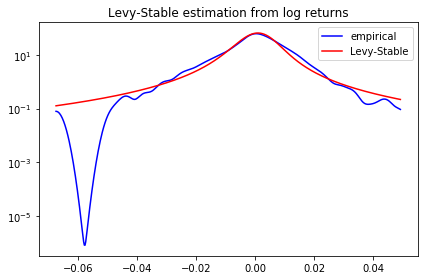

In [9]:
# find density from levy stable distribution fit
levy_pdf = levy_stable.pdf(x, alpha, beta, mu, sigma)
plot_model_pdf(kde_pdf, levy_pdf, 'Levy-Stable', plot_log=True)

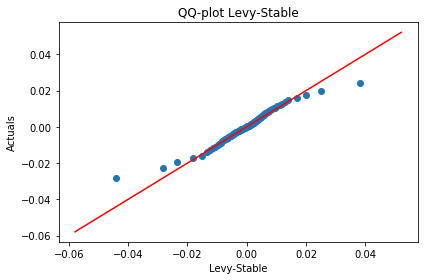

In [10]:
# Display QQ-Plot
levy_sim = levy_stable.rvs(alpha, beta, loc=mu, scale=sigma, size=y.shape[0], random_state=42)
qq_plot(y, levy_sim, 'Levy-Stable')

### Student's T Distribution

In [11]:
from scipy.stats import t
t_df, t_loc, t_scale = t.fit(y)

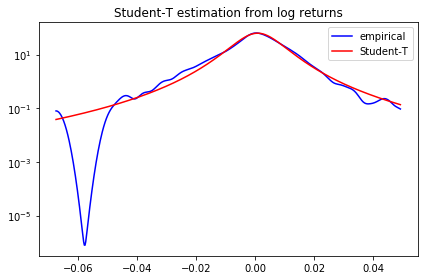

In [12]:
# find limits and generate linspace
xmin, xmax = y.min(), y.max()
x = np.linspace(xmin, xmax, min(500, y.shape[0]))

# find pdf from normal distribution fit
t_pdf = t.pdf(x, t_df, t_loc, t_scale)
plot_model_pdf(kde_pdf, t_pdf, 'Student-T', plot_log=True)

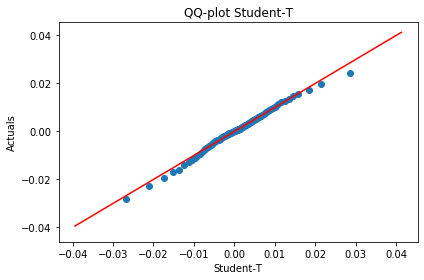

In [13]:
# Display QQ-Plot
t_sim = t.rvs(t_df, loc=t_loc, scale=t_scale, size=y.shape[0], random_state=42)
qq_plot(y, t_sim, 'Student-T')

### Non-Central Student's T Distribution

In [14]:
from scipy.stats import nct
nct_df, nct_nc, nct_loc, nct_scale = nct.fit(y)

c:\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


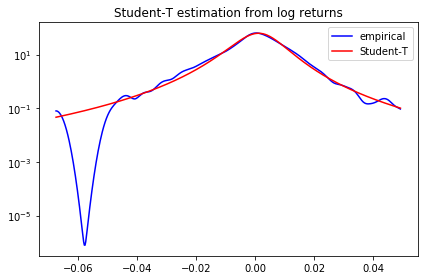

In [15]:
# find limits and generate linspace
xmin, xmax = y.min(), y.max()
x = np.linspace(xmin, xmax, min(500, y.shape[0]))

# find pdf from normal distribution fit
nct_pdf = nct.pdf(x, nct_df, nct_nc, nct_loc, nct_scale)
plot_model_pdf(kde_pdf, nct_pdf, 'Student-T', plot_log=True)

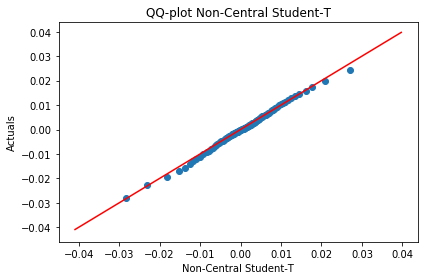

In [16]:
# Display QQ-Plot
nct_sim = nct.rvs(nct_df, nct_nc, loc=nct_loc, scale=nct_scale, size=y.shape[0], random_state=42)
qq_plot(y, nct_sim, 'Non-Central Student-T')

## Evaluation

Test the results against each other and compare

### Normality

In [17]:
# Anderson-Darling test for normality
anderson_stat, anderson_crit, anderson_sig = stats.anderson(y, 'norm')

print('Anderson-Darling Test results (Normality):')
print('- stat: {}\tcritical: {}\tsignificance: {}%'.format(anderson_stat, anderson_crit[2], anderson_sig[2]))
anderson_accept_null = anderson_stat <= anderson_crit[2]
print('- Accept the null hypothesis that stat <= critical value (5%): {}'.format(anderson_accept_null))
if anderson_accept_null:
    print('- Data IS distributed normally!')
else:
    print('- Data IS NOT distributed normally!')
    
# Shapiro-Wilk test for normality
shapiro_stat, shapiro_pvalue = stats.shapiro(y)

print('\nShapiro-Wilk Test results (Normality):')
print('- stat: {}\tpvalue: {}'.format(shapiro_stat, shapiro_pvalue))
shapiro_accept_null = shapiro_pvalue >= 0.05
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(shapiro_accept_null))
if shapiro_accept_null:
    print('- Data IS distributed normally!')
else:
    print('- Data IS NOT distributed normally!')
    
# KS test for goodness-of-fit for distribution (Normal)
ks_norm = kstest(y, 'norm')

print('\nKS Test results (Normal Distribution):')
print('- stat: {}\tpvalue: {}'.format(ks_norm.statistic, ks_norm.pvalue))
ks_accept_null = ks_norm.pvalue >= 0.05
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(ks_accept_null))
if ks_accept_null:
    print('- Data IS distributed normally!')
else:
    print('- Data IS NOT distributed normally!')

print('\n{}/3 test positive for Normality.'.format(np.sum([anderson_accept_null, shapiro_accept_null, ks_accept_null])))

Anderson-Darling Test results (Normality):
- stat: 37.21998579003139	critical: 0.786	significance: 5.0%
- Accept the null hypothesis that stat <= critical value (5%): False
- Data IS NOT distributed normally!

Shapiro-Wilk Test results (Normality):
- stat: 0.9427188038825989	pvalue: 2.3454014359357946e-30
- Accept the null hypothesis that pvalue >= 0.05: False
- Data IS NOT distributed normally!

KS Test results (Normal Distribution):
- stat: 0.48410369646921725	pvalue: 0.0
- Accept the null hypothesis that pvalue >= 0.05: False
- Data IS NOT distributed normally!

0/3 test positive for Normality.


### Error Statistics

In [18]:
def error_stats(actuals, predicted, num_param):
    q_size = 1000
    quantiles = np.linspace(1 / q_size, 1 - (1 / q_size), q_size)
    actuals_q = np.quantile(actuals, quantiles) 
    predicted_q = np.quantile(predicted, quantiles)
    
    df = q_size - num_param - 1
    
    actuals = np.sort(actuals_q)
    predicted = np.sort(predicted_q)

    # Find error statistics
    residuals = actuals - predicted
    res_student = residuals / np.std(residuals)
    
    mse = sum(residuals**2) / df
    rmsd = np.sqrt(mse)
    nrmsd = rmsd / (max(actuals) - min(actuals))
    msd = sum(-residuals) / df
    mae = sum(abs(residuals)) / df
    smape = sum(abs(predicted - actuals) / (abs(actuals) + abs(predicted))) / df
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(actuals, predicted)
    r_square = r_value**2
    
    return ([mse, rmsd, nrmsd, msd, mae, smape, r_square],
            ['MSE', 'RMSD', 'nRMSD', 'MSD', 'MAE', 'sMAPE', 'R-Square'])

normal_error_stats, test_names = error_stats(y, normal_sim, 2)
levy_error_stats,   test_names = error_stats(y, levy_sim, 4)
t_error_stats,      test_names = error_stats(y, t_sim, 3)
nct_error_stats,    test_names = error_stats(y, nct_sim, 4)

error_stats_df = pd.DataFrame()
error_stats_df['Normal'] = normal_error_stats
error_stats_df['Levy-Stable'] = levy_error_stats
error_stats_df['Student-T'] = t_error_stats
error_stats_df['Non-Central T'] = nct_error_stats
error_stats_df.index = test_names

pd.set_option('display.float_format', lambda x: '%f' % x)
print(error_stats_df)

error_stats_df.loc['R-Square'] = 1 - error_stats_df.loc['R-Square']
print('\nCounts of Best Values:')
print(abs(error_stats_df).idxmin(axis=1))
print()
print(abs(error_stats_df).idxmin(axis=1).value_counts())

            Normal  Levy-Stable  Student-T  Non-Central T
MSE       0.000004     0.000029   0.000001       0.000003
RMSD      0.001924     0.005405   0.001183       0.001709
nRMSD     0.021849     0.061388   0.013437       0.019412
MSD      -0.000102    -0.000245   0.000133       0.000288
MAE       0.001471     0.001331   0.000520       0.000542
sMAPE     0.201358     0.083080   0.070410       0.084214
R-Square  0.957691     0.875225   0.984627       0.973226

Counts of Best Values:
MSE         Student-T
RMSD        Student-T
nRMSD       Student-T
MSD            Normal
MAE         Student-T
sMAPE       Student-T
R-Square    Student-T
dtype: object

Student-T    6
Normal       1
dtype: int64


### Goodness of Fit

In [19]:
# Test goodness of fit for both models
ks_norm = kstest(y, 'norm')
ks_levy = kstest(y, lambda x: levy_stable.cdf(x, alpha, beta, mu, sigma))
ks_t    = kstest(y, lambda x: t.cdf(x, t_df, t_loc, t_scale))
ks_nct  = kstest(y, lambda x: nct.cdf(x, nct_df, nct_nc, nct_loc, nct_scale))

print('KS Test results (Normal):')
print('- stat: {}\tpvalue: {}'.format(ks_norm.statistic, ks_norm.pvalue))
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(ks_norm.pvalue >= 0.05))

print('\nKS Test results (Levy-Stable):')
print('- stat: {}\tpvalue: {}'.format(ks_levy.statistic, ks_levy.pvalue))
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(ks_levy.pvalue >= 0.05))

print('\nKS Test results (Student-T):')
print('- stat: {}\tpvalue: {}'.format(ks_t.statistic, ks_t.pvalue))
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(ks_t.pvalue >= 0.05))

print('\nKS Test results (Non-Central Student-T):')
print('- stat: {}\tpvalue: {}'.format(ks_nct.statistic, ks_nct.pvalue))
print('- Accept the null hypothesis that pvalue >= 0.05: {}'.format(ks_nct.pvalue >= 0.05))

KS Test results (Normal):
- stat: 0.48410369646921725	pvalue: 0.0
- Accept the null hypothesis that pvalue >= 0.05: False

KS Test results (Levy-Stable):
- stat: 0.031580574920624715	pvalue: 0.012118787267858937
- Accept the null hypothesis that pvalue >= 0.05: False

KS Test results (Student-T):
- stat: 0.021261191136424773	pvalue: 0.1994207042891885
- Accept the null hypothesis that pvalue >= 0.05: True

KS Test results (Non-Central Student-T):
- stat: 0.02335931029289684	pvalue: 0.12382925089589816
- Accept the null hypothesis that pvalue >= 0.05: True
